# Part 1: Data Preparation & EDA

**Contesting Gender Equality? A Computational Analysis of Backlash in Gender-Related News Media**

A Semester Project by Julia Jensine Häfker

MSc. Business Data Science

Aalborg University

Hand In: 17.12.2026

# Setup for Analysis

## Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from typing import Any, Dict, List, Optional
from math import floor
import matplotlib.pyplot as plt
from collections import Counter

import json, re, os, warnings
warnings.filterwarnings("ignore")

## Import Data

Loading the data from a local source into a pandas df. The following code extracts the json files from separate folders. The folders determine the year the contained articles are from. The structure of the JSON Files will be ensured.

In [2]:
BASE_DIR = Path("/Users/juliahafker/Desktop/02_Code/01_Data/corpus")

def _safe_str(value: Any) -> str:
    return (value or "").strip() if value is not None else ""

def _to_bool(value: Any) -> Optional[bool]:
    if value is None:
        return None
    if isinstance(value, bool):
        return value
    if isinstance(value, (int, float)):
        return bool(value)
    if isinstance(value, str):
        v = value.strip().lower()
        if v in {"true", "1", "yes", "y", "t"}:
            return True
        if v in {"false", "0", "no", "n", "f"}:
            return False
    return None

def _keywords_to_list(keywords: Any) -> List[str]:
    if keywords is None:
        return []
    if isinstance(keywords, list):
        return [str(k).strip() for k in keywords if str(k).strip()]
    # assume string: comma or semicolon separated
    if isinstance(keywords, str):
        parts = [p.strip() for p in keywords.replace(";", ",").split(",")]
        return [p for p in parts if p]
    return []

def _safe_int(value: Any) -> Optional[int]:
    try:
        if value is None:
            return None
        return int(value)
    except Exception:
        return None

def _extract_record(aid: str, year: int, json_path: Path, article_obj: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    if not isinstance(article_obj, dict):
        return None

    meta = article_obj.get("meta_data") or {}
    txt = article_obj.get("text") or {}

    title = _safe_str(txt.get("title"))
    teaser = _safe_str(txt.get("teaser"))
    body = _safe_str(txt.get("text"))

    if not (title or body):
        # skip records that have neither title nor body
        return None

    published_raw = _safe_str(meta.get("published_on") or meta.get("crawled_on") or "")
    crawled_raw = _safe_str(meta.get("crawled_on") or meta.get("published_on") or "")

    keywords_raw = meta.get("keywords")
    keywords_list = _keywords_to_list(keywords_raw)

    record = {
        "article_id": str(aid),
        "year": year,
        "source_file": str(json_path),
        "title": title,
        "teaser": teaser,
        "text": body,
        # raw metadata values
        "published_on_raw": published_raw,
        "crawled_on_raw": crawled_raw,
        "author": _safe_str(meta.get("author")),
        "language": _safe_str(meta.get("language")),
        "type": _safe_str(meta.get("type")),
        "contains_actors": _to_bool(meta.get("contains_actors")),
        "keywords_raw": _safe_str(keywords_raw) if isinstance(keywords_raw, str) else None,
        "keywords": keywords_list,
        "token_count": _safe_int(meta.get("token_count"))
    }

    return record

def load_corpus_minimal(base_dir: Path) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []
    base_dir = Path(base_dir)

    for year_dir in sorted(base_dir.iterdir()):
        if not year_dir.is_dir() or not year_dir.name.isdigit():
            continue
        year = int(year_dir.name)
        for json_path in sorted(year_dir.glob("*.json")):
            text = json_path.read_text(encoding="utf-8", errors="replace").strip()
            if not text:
                continue
            try:
                payload = json.loads(text)
            except Exception:
                # skip files that are not valid JSON
                continue

            # mapping id -> article_obj
            if isinstance(payload, dict):
                for aid, obj in payload.items():
                    rec = _extract_record(aid, year, json_path, obj if isinstance(obj, dict) else {})
                    if rec:
                        records.append(rec)

            # list of article-like objects
            elif isinstance(payload, list):
                for idx, obj in enumerate(payload):
                    if isinstance(obj, dict) and len(obj) == 1:
                        aid, article_obj = next(iter(obj.items()))
                    else:
                        aid = f"{json_path.stem}_{idx}"
                        article_obj = obj if isinstance(obj, dict) else {}
                    rec = _extract_record(aid, year, json_path, article_obj)
                    if rec:
                        records.append(rec)

    df = pd.DataFrame.from_records(records, columns=[
        "article_id", "year", "source_file", "title", "teaser", "text",
        "published_on_raw", "crawled_on_raw", "author", "language", "type",
        "contains_actors", "keywords_raw", "keywords", "token_count"
    ])

    # parse date columns to datetimes where possible (NaT when parsing fails)
    for col in ("published_on_raw", "crawled_on_raw"):
        df[col.replace("_raw", "")] = pd.to_datetime(df[col], errors="coerce", utc=True)

    return df.reset_index(drop=True)

# Usage
df = load_corpus_minimal(BASE_DIR)
print("Loaded articles:", len(df))
df.head(5)

Loaded articles: 1834026


,article_id,year,source_file,title,teaser,text,published_on_raw,crawled_on_raw,author,language,type,contains_actors,keywords_raw,keywords,token_count,published_on,crawled_on
0,1060458,1980,/Users/juliahafker/Desktop/02_Code/01_Data/cor...,Dem Andenken Rudi Dutschkes,Christian Semler zum Tode eines Freundes und G...,Von Christian Semler Erstveröffentlichung in: ...,1980-01-01T00:00:00+01:00,2024-09-30 22:48,Christian Semler,de,article,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",2748,1979-12-31 23:00:00+00:00,2024-09-30 22:48:00+00:00
1,1060457,1983,/Users/juliahafker/Desktop/02_Code/01_Data/cor...,Der Papst in Polen: Injektion der Hoffnung,,Von Christian Semler Erstveröffentlichung in: ...,1983-07-01T00:00:00+01:00,2024-09-30 22:48,Christian Semler,de,article,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",2692,1983-06-30 23:00:00+00:00,2024-09-30 22:48:00+00:00
2,1060456,1984,/Users/juliahafker/Desktop/02_Code/01_Data/cor...,Polnischer Monolog oder westlich-intellektuell...,,Von Christian Semler Erstveröffentlichung in: ...,1984-11-01T00:00:00+01:00,2024-09-30 22:47,Christian Semler,de,article,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",1881,1984-10-31 23:00:00+00:00,2024-09-30 22:47:00+00:00
3,1060455,1985,/Users/juliahafker/Desktop/02_Code/01_Data/cor...,Der Macht gegenüber politisch verhalten,Die Bedeutung des „Prager Aufrufs“ für die Fri...,Von Christian Semler Erstveröffentlichung in: ...,1985-05-01T00:00:00+01:00,2024-09-30 22:47,Christian Semler,de,article,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",3717,1985-04-30 23:00:00+00:00,2024-09-30 22:47:00+00:00
4,1060454,1985,/Users/juliahafker/Desktop/02_Code/01_Data/cor...,„Anlaß zur Unruhe“*,Anmerkungen zu Agnes Hellers und Ferenc Fehers...,Von Dieter Esche und Christian Semler *** Erst...,1985-07-01T00:00:00+01:00,2024-09-30 22:47,Dieter Esche / Christian Semler,de,article,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",12503,1985-06-30 23:00:00+00:00,2024-09-30 22:47:00+00:00


# 1. Cleaning Data for Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834026 entries, 0 to 1834025
Data columns (total 17 columns):
 #   Column            Dtype              
---  ------            -----              
 0   article_id        object             
 1   year              int64              
 2   source_file       object             
 3   title             object             
 4   teaser            object             
 5   text              object             
 6   published_on_raw  object             
 7   crawled_on_raw    object             
 8   author            object             
 9   language          object             
 10  type              object             
 11  contains_actors   bool               
 12  keywords_raw      object             
 13  keywords          object             
 14  token_count       int64              
 15  published_on      datetime64[ns, UTC]
 16  crawled_on        datetime64[ns, UTC]
dtypes: bool(1), datetime64[ns, UTC](2), int64(2), object(12)
memory u

## 1.1. Clean Columns

### 1.1.1. Drop unneccessary columns

As this is a german dataset, we will drop the language column.

In [4]:
# making sure the language is "de" in all entries
df['language'].unique()

array(['de'], dtype=object)

In [5]:
# dropping the language column
df = df.drop(columns=['language'])

Additionally the "published_on" and "crawled_on" columns are not necessary. 

The publication date will only be evaluated on a yearly base. Year has separate column. "crawled_on" is irrelevant metadata.

In [6]:
df = df.drop(columns=['published_on_raw'])

df = df.drop(columns=['published_on'])

df = df.drop(columns=['crawled_on_raw'])

df = df.drop(columns=['crawled_on'])

Check on unique values for type to see if this gives any interesting information.

In [7]:
df['type'].unique()

array(['article'], dtype=object)

They are all "articles", so there is no information for the analysis.

In [8]:
df = df.drop(columns=['type'])

All files lie in the same folder. "source_file" is therefore not interesting.

In [9]:
df = df.drop(columns=['source_file'])

### 1.1.2. Convert suitable object columns to category

In [10]:
cat_candidates = ['source_file', 'language', 'author', 'type']
for c in cat_candidates:
    if c in df.columns:
        nunique = df[c].nunique(dropna=False)
        pct_unique = nunique / len(df)
        # Heuristic: convert if unique fraction is small (e.g. < 0.5 or you know it's low-cardinality)
        if pct_unique < 0.5:
            df[c] = df[c].astype('category')
            print(f"Converted {c} to category ({nunique} unique, {pct_unique:.3f} fraction)")

Converted author to category (65683 unique, 0.036 fraction)


Final check to make sure all relevant columns are kept and the cleaning has been executed.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834026 entries, 0 to 1834025
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   article_id       object  
 1   year             int64   
 2   title            object  
 3   teaser           object  
 4   text             object  
 5   author           category
 6   contains_actors  bool    
 7   keywords_raw     object  
 8   keywords         object  
 9   token_count      int64   
dtypes: bool(1), category(1), int64(2), object(6)
memory usage: 123.2+ MB


## 1.2. Checking for missing values

### 1.2.1. General check for missing values

In [12]:
df.isna().sum()

article_id         0
year               0
title              0
teaser             0
text               0
author             0
contains_actors    0
keywords_raw       0
keywords           0
token_count        0
dtype: int64

No missing values detected. Further analysis to be conducted.

### 1.2.2. Further Analysis of Missing Values

As we working with a lot of text data, missing values might not be that easily detected. Cases can contain whitespace or invisible characters.

In [13]:
# find titles which are empty or contain only whitespace
mask_empty_after_strip = df["title"].astype(str).str.strip() == ""
df[mask_empty_after_strip]

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count
593448,1267540,1999,,■ Großbritannien darf den chilenischen Ex-Dik...,Dublin (taz) – Augosto Pinochet darf nach Span...,Ralf Sotscheck,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",532
593452,1267544,1999,,■ In Spanien sammelt der Ankläger Augusto Pino...,Madrid (taz) – „El pueblo unido jamás será ven...,Reiner Wandler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",624
593461,1267553,1999,,■ Unwetter fordert in Mexiko 239 Tote. Behörde...,Puebla (rtr) – Bei Unwettern mit heftigen Rege...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",133
593462,1267554,1999,,,Bayreuth (dpa) – In Deutschland begehen jährli...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",126
593463,1267555,1999,,,Luxemburg (AFP) – Anhaltender Widerstand Luxem...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",78
...,...,...,...,...,...,...,...,...,...,...
1441655,0347354,2014,,Braunschweig II – Neumünster 1:1 Wolfsburg II ...,Wolfsburg II 34 57 74 Werder II 34 30 73 Olden...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",79
1441970,0350319,2014,,Hannover II – Wolfsburg II 0:1 Goslar – Werder...,Wolfsburg II 33 56 71 Werder II 33 25 70 Olden...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",79
1449416,0319019,2014,,Norderstedt – Neumünster 2:1 Wolfsburg II – Re...,Hamburg II 1 +4 3 Meppen 1 +2 3 Wolfsburg II 1...,taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",79
1463136,0276706,2014,,,KURZMELDUNG Endgültig grünes Licht für Suhrkam...,drk,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",48


In [14]:
# find teaser which are empty or contain only whitespace
mask_empty_after_strip = df["teaser"].astype(str).str.strip() == ""
df[mask_empty_after_strip]

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count
1,1060457,1983,Der Papst in Polen: Injektion der Hoffnung,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",2692
2,1060456,1984,Polnischer Monolog oder westlich-intellektuell...,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",1881
6,1060453,1985,Wahl in Polen: Ermutigend,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",758
7,1060452,1986,Erinnerungen an das Gewaltmonopol,,Von Christian Semler Erstveröffentlichung in: ...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",6549
8,1877245,1986,F A L L O B S T Vom Restrisiko,,„Die Zuversicht an den Sinn des technischen Fo...,Heiner Geißler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",55
...,...,...,...,...,...,...,...,...,...,...
1834012,6038079,2024,verboten​,,"Gerade jetzt, wo der Rechtsextremismus weiter ...",,True,,[],137
1834014,6038081,2024,Tiefe Trauer und schwere Vorwürfe​,,"Gerade jetzt, wo der Rechtsextremismus weiter ...",,True,,[],137
1834015,6038082,2024,​,,"Gerade jetzt, wo der Rechtsextremismus weiter ...",,True,,[],137
1834016,6038083,2024,​,,"Gerade jetzt, wo der Rechtsextremismus weiter ...",,True,,[],137


In [15]:
# find text which are empty or contain only whitespace
mask_empty_after_strip = df["text"].astype(str).str.strip() == ""
df[mask_empty_after_strip]

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count


**Results:**

425 rows don't contain a title.

914614 rows don't contain a teaser.

But all rows contain a text, which is most important for us and the base for our analysis.

Therefore no rows will be dropped.

## 1.3. Checking for Duplicates

In [16]:
dups_id = df[df.duplicated(subset=["text"], keep=False)]
print("Duplicates by text:", len(dups_id))
dups_id.sort_values("text").head()

Duplicates by text: 16172


,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count
1365793,542099,2012,Lokalprärie,,"""Auto + Fahrer - für dies & das!"" Ich fahre al...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",67
1365705,541827,2012,Lokalprärie,,"""Auto + Fahrer - für dies & das!"" Ich fahre al...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",67
1366020,542943,2012,Lokalprärie,,"""Auto + Fahrer - für dies & das!"" Ich fahre al...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",67
1366580,541147,2012,Lokalprärie,,"""Auto + Fahrer - für dies & das!"" Ich fahre al...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",67
1364391,539737,2012,Lokalprärie,,"""Auto + Fahrer - für dies & das!"" Ich fahre al...",taz. die tageszeitung,False,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",115


There are 16172 duplicates in the text column. We will drop all of them but keep the first occurence.

In [17]:
df_no_dups = df.drop_duplicates(subset=["text"], keep="first")

Again I will check on the execution of the cleaning step.

In [18]:
print(df.shape)

(1834026, 10)


## 1.4. Cleaning the Keyword Column

The Keyword Column is currently an object. In the following it will be turned into a string.

In [19]:
CLEAN_RE_URL = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
CLEAN_RE_WS  = re.compile(r"\s+")

def clean_keyword_entry(entry):
    # handle None, NaN
    if entry is None or (isinstance(entry, float) and pd.isna(entry)):
        return []

    # Case 1: Already a list or array → clean each item
    if isinstance(entry, (list, np.ndarray)):
        cleaned = []
        for item in entry:
            if isinstance(item, str):
                item = item.lower()
                item = CLEAN_RE_URL.sub(" ", item)
                item = CLEAN_RE_WS.sub(" ", item).strip()
                if item:
                    cleaned.append(item)
        return cleaned

    # Case 2: It's a string → split into keywords
    if isinstance(entry, str):
        s = entry.lower()
        s = CLEAN_RE_URL.sub(" ", s)

        # split on common separators
        parts = re.split(r"[;,/|\s]+", s)
        parts = [p.strip() for p in parts if p.strip()]
        return parts

    # Unknown type → convert to string and treat it as one keyword
    s = str(entry).lower().strip()
    return [s] if s else []

In [20]:
df['keywords_cleaned'] = df['keywords'].apply(clean_keyword_entry)

## 1.5. Create a stratified sample (for the zero-shot extraction)

In the following I will pull a stratified sample (by year) from the df, which then will be used for a zero-shot classification using a LLM. 

The data from some years are too small to create a 2k sample, so some rows are being duplicated to keep the sample stratified.

In [ ]:
def stratified_sample_exact(df, group_col, n, random_state=42):
    rng = np.random.RandomState(random_state)
    counts = df[group_col].value_counts(sort=False)
    props = counts / counts.sum()

    # initial integer allocation (floor), then distribute remainder by largest fractional parts
    raw_alloc = props * n
    alloc_floor = raw_alloc.apply(floor).astype(int)
    remainder = n - alloc_floor.sum()

    # allocate leftover one-by-one to groups with largest fractional part
    frac_parts = (raw_alloc - alloc_floor)
    if remainder > 0:
        extra_idx = frac_parts.sort_values(ascending=False).index.tolist()[:remainder]
        for g in extra_idx:
            alloc_floor[g] += 1

    samples = []
    for group, k in alloc_floor.items():
        grp_df = df[df[group_col] == group]
        # if the group has fewer rows than required, sample with replacement just for that group
        replace = len(grp_df) < k
        if k == 0:
            continue
        sampled = grp_df.sample(n=k, replace=replace, random_state=rng)
        samples.append(sampled)

    result = pd.concat(samples, ignore_index=True)
    # final sanity: if rounding oddities changed size, adjust deterministically
    if len(result) > n:
        result = result.sample(n=n, random_state=rng).reset_index(drop=True)
    elif len(result) < n:
        # sample additional rows from full df (allow replacement) to reach n
        needed = n - len(result)
        extra = df.sample(n=needed, replace=True, random_state=rng)
        result = pd.concat([result, extra], ignore_index=True).reset_index(drop=True)

    return result.reset_index(drop=True)

# Usage
N = 2000
sample_df = stratified_sample_exact(df, group_col="year", n=N, random_state=42)

In [ ]:
# export to JSONL (NDJSON)
output_path = "gender_classification_sample_full2k.jsonl"

with open(output_path, "w", encoding="utf-8") as f:
    for _, row in sample_df.iterrows():
        f.write(row.to_json(force_ascii=False) + "\n")

print(f"Saved to {output_path}")

# 2. Exploratory Data Analysis (General)

This section aims to understand the simple outline of the dataset and get a first impression of the data.

## 2.1. Amount of Articles per Year

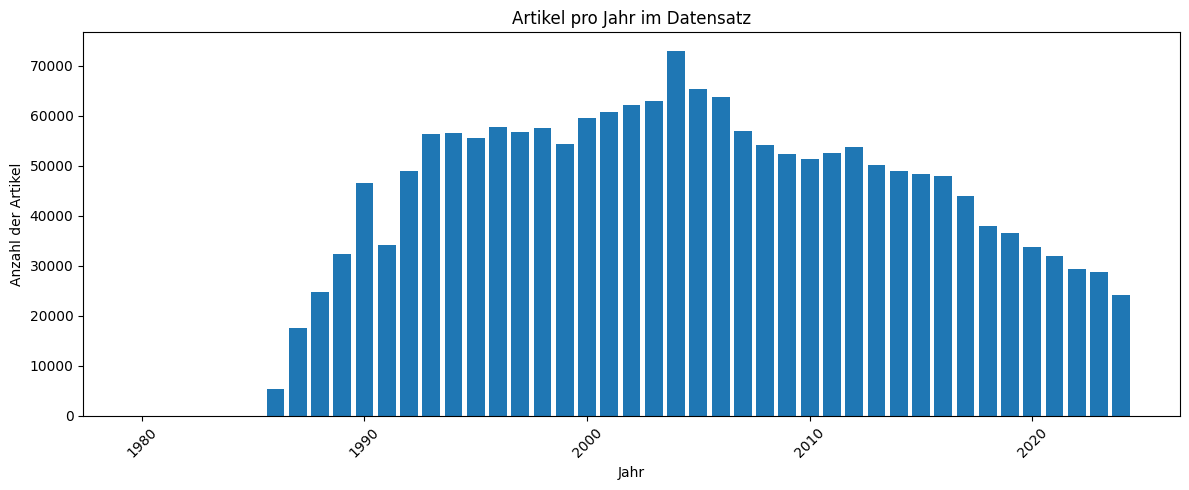

In [21]:
# Group and count
year_counts = df["year"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Artikel")
plt.title("Artikel pro Jahr im Datensatz")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.2. Length of Articles

### 2.2.1. Histogram of article length

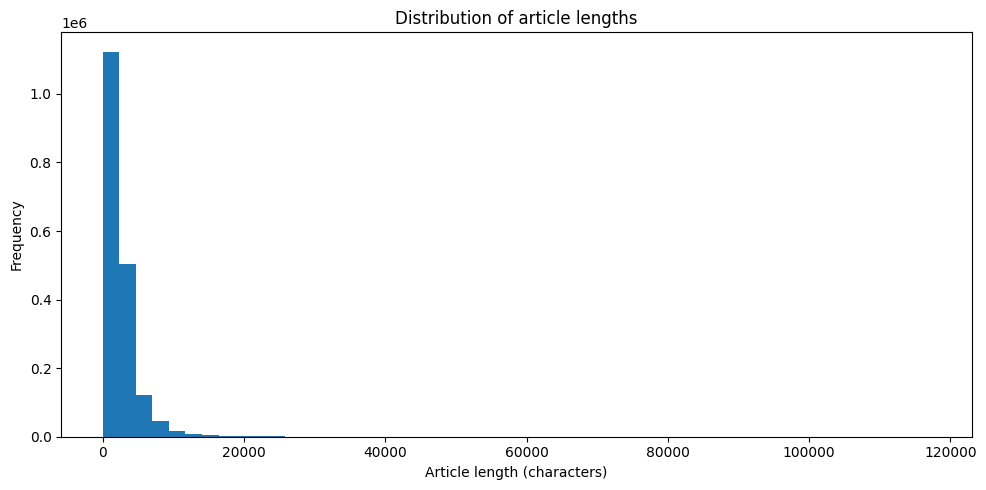

In [22]:
# compute article length in tokens or characters
df["length_chars"] = df["text"].str.len()

plt.figure(figsize=(10,5))
plt.hist(df["length_chars"], bins=50)
plt.xlabel("Article length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of article lengths")
plt.tight_layout()
plt.show()

### 2.2.2. Boxplot to identify outliers

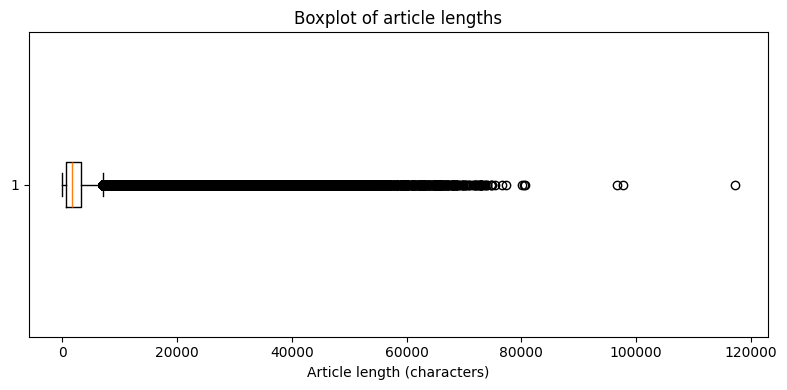

In [23]:
# compute article length if not already done
df["length_chars"] = df["text"].str.len()

plt.figure(figsize=(8, 4))
plt.boxplot(df["length_chars"], vert=False)
plt.xlabel("Article length (characters)")
plt.title("Boxplot of article lengths")
plt.tight_layout()
plt.show()


### 2.2.3. Mean Length

In [24]:
mean_length = df["length_chars"].mean()
mean_length

2380.0909441850877

### 2.2.4. Lenght by year

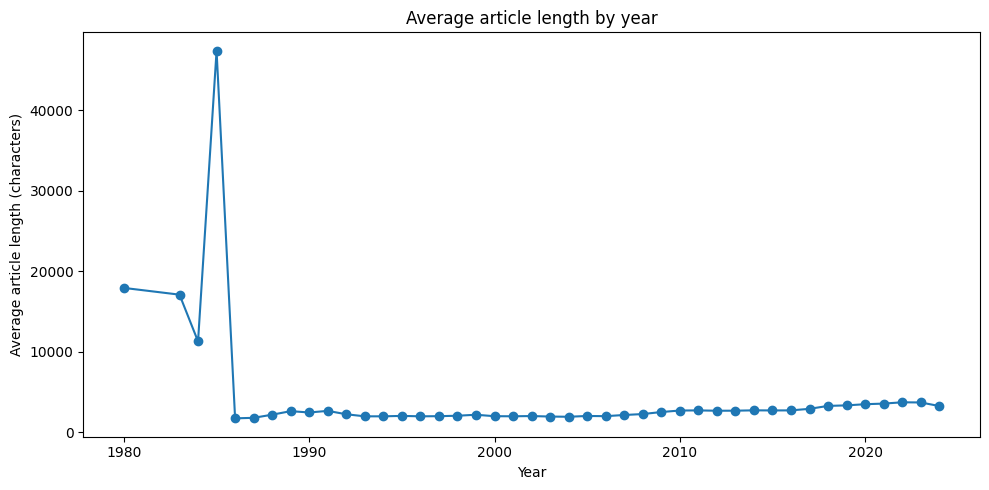

In [25]:
df["length_chars"] = df["text"].str.len()

year_lengths = df.groupby("year")["length_chars"].mean()

plt.figure(figsize=(10,5))
plt.plot(year_lengths.index, year_lengths.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Average article length (characters)")
plt.title("Average article length by year")
plt.tight_layout()
plt.show()

### 2.2.5. Inspect longest articles

In [26]:
# Compute article length
df["length_chars"] = df["text"].str.len()

# Get top 10 longest articles
top10 = df.nlargest(10, "length_chars")
top10

,article_id,year,title,teaser,text,author,contains_actors,keywords_raw,keywords,token_count,keywords_cleaned,length_chars
1479355,2748146,2015,"berlinaleprogramm, 5.2. – 15.2.2015",,20:30 Friedrichstadtpalast: Nobody Wants the N...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",26855,"[archiv, archiv, nachrichten, news, taz, tages...",117172
1552517,5342628,2016,Umfrage unter Europaabgeordneten: Was zeichnet...,"Wir haben die Europaparlamentarier gefragt, wa...",Wir haben allen Abgeordneten des Europäischen ...,taz. die tageszeitung,True,"Europäische Union, Europäische Integration, Eu...","[Europäische Union, Europäische Integration, E...",15506,"[europäische union, europäische integration, e...",97697
1585628,5698888,2017,Chronik tödlicher Polizeischüsse seit 1990: 26...,Alle fünfeinhalb Wochen wird in Deutschland ei...,Manuel F. steht splitternackt im Neptunbrunnen...,Erik Peter,True,"Polizeigewalt, Tödliche Polizeischüsse, Report...","[Polizeigewalt, Tödliche Polizeischüsse, Repor...",17131,"[polizeigewalt, tödliche polizeischüsse, repor...",96623
4,1060454,1985,„Anlaß zur Unruhe“*,Anmerkungen zu Agnes Hellers und Ferenc Fehers...,Von Dieter Esche und Christian Semler *** Erst...,Dieter Esche / Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",12503,"[archiv, archiv, nachrichten, news, taz, tages...",80607
5,3107678,1985,„Anlaß zur Unruhe“*,Anmerkungen zu A. Hellers und F. Fehérs Rapall...,Von Dieter Esche/ Christian Semler Erstveröffe...,Christian Semler,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",12471,"[archiv, archiv, nachrichten, news, taz, tages...",80527
1393529,5068295,2013,+++ Ticker zum 1. Mai 2013 +++: Keine Lust auf...,Eine blockierte Nazidemo und eine die laufen d...,Wir machen jetzt Schluss. Wer die üblichen Tru...,taz. die tageszeitung,True,"Berlin-Kreuzberg, Hamburger Bahnhof, Frankfurt...","[Berlin-Kreuzberg, Hamburger Bahnhof, Frankfur...",13546,"[berlin-kreuzberg, hamburger bahnhof, frankfur...",80182
1510809,5244109,2015,"Sonnabend, 24. Oktober 2015",,23. Pankower Winzerfest (☎ 65763560)Weingüter ...,taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",15688,"[archiv, archiv, nachrichten, news, taz, tages...",77362
1660274,5586575,2019,11. 04. – 17. 04. 2019,,"Astor Film Lounge, Kurfürstendamm 225, Tel. 88...",taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",18875,"[archiv, archiv, nachrichten, news, taz, tages...",76655
1658786,5581198,2019,21. 03. – 27. 03. 2019,,"Astor Film Lounge, Kurfürstendamm 225, Tel. 88...",taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",18974,"[archiv, archiv, nachrichten, news, taz, tages...",75351
1684880,5648441,2019,12. 12. – 18. 12. 2019,,"Astor Film Lounge, Kurfürstendamm 225, Tel. 88...",taz. die tageszeitung,True,"Archiv, Archiv, Nachrichten, News, taz, tagesz...","[Archiv, Archiv, Nachrichten, News, taz, tages...",18698,"[archiv, archiv, nachrichten, news, taz, tages...",74816


The data shows some quite significant outliers for the length columns. When inspecting the data in detail we can see that these are (among other types) "live-ticker" or programs for the cinema or other events. To reliably clean, one would have to dig deeper into the different types and sort them by a reproducable pattern. 

As these articles are not creating any kind of problematic noice for the analysis, they will simply be kept in the dataframe.

## 2.3. Inspect Keywords

### 2.3.1. All unique Keywords

In [47]:
# explode the list column into rows
unique_keywords = (
    df.explode("keywords")["keywords"]
      .dropna()
      .unique()
)

print("Number of unique keywords:", len(unique_keywords))
unique_keywords

Number of unique keywords: 15668


array(['Archiv', 'Nachrichten', 'News', ..., 'LGBTQIA-Communities',
       'Landlosenbewegung', 'Landreform'], shape=(15668,), dtype=object)

### 2.3.2. Sorted List of Keywords

In [48]:
unique_keywords_sorted = sorted(
    k for k in df.explode("keywords")["keywords"].dropna().unique()
)

unique_keywords_sorted[:50]  # preview first 50


['"Arisierung"',
 '"No Billag"-Initiative',
 '"Querdenken"-Bewegung',
 '#Aufschrei',
 '#Brennifer',
 '#Me too',
 '#MeTwo',
 '#NotTooYoungToRun',
 '#Unteilbar',
 '#Yachtfleet',
 '#ausnahmslos',
 '#freelorde',
 '#freethemall',
 '#jetzterstrecht',
 '#metoo',
 '#noNPOG',
 '#vonhier',
 '007',
 '08/15',
 '1. Bundesliga',
 '1. FC Heidenheim',
 '1. FC Kaiserslautern',
 '1. FC Nürnberg',
 '1. Mai',
 '1. Mai in Berlin',
 '1.FC Köln',
 '100 Jahre Oktoberrevolution',
 '100. Geburtstag',
 '12 Years a Slave',
 '13',
 '19. Jahrhundert',
 '1914',
 '1968',
 '1989',
 '1990',
 '2-Grad-Ziel',
 '2. Bundesliga',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2019',
 '2020',
 '2020 in guten Nachrichten',
 '2050 – die',
 '3-D-Drucker',
 '30 Jahre friedliche Revolution',
 '30-Stunden-Woche',
 '30C3']

### 2.3.3. Keyword Frequency

In [49]:
keyword_counts = (
    df.explode("keywords")["keywords"]
      .value_counts()
)

keyword_counts

keywords
Archiv             3061760
taz                1829390
tageszeitung       1829307
Nachrichten        1623840
News               1623783
                    ...   
Havanna Acht             1
Sinkane                  1
Landreform               1
Allergie                 1
AKW Brunsbüttel          1
Name: count, Length: 15668, dtype: int64

### 2.3.4. WordCloud Keywords

Saved word cloud to: /Users/juliahafker/Library/Mobile Documents/com~apple~CloudDocs/Documents/Bildung /2023_MA Uni Hamburg/WiSe25_Semester Project/02_Code/Semester_Project/keywords_wordcloud.png


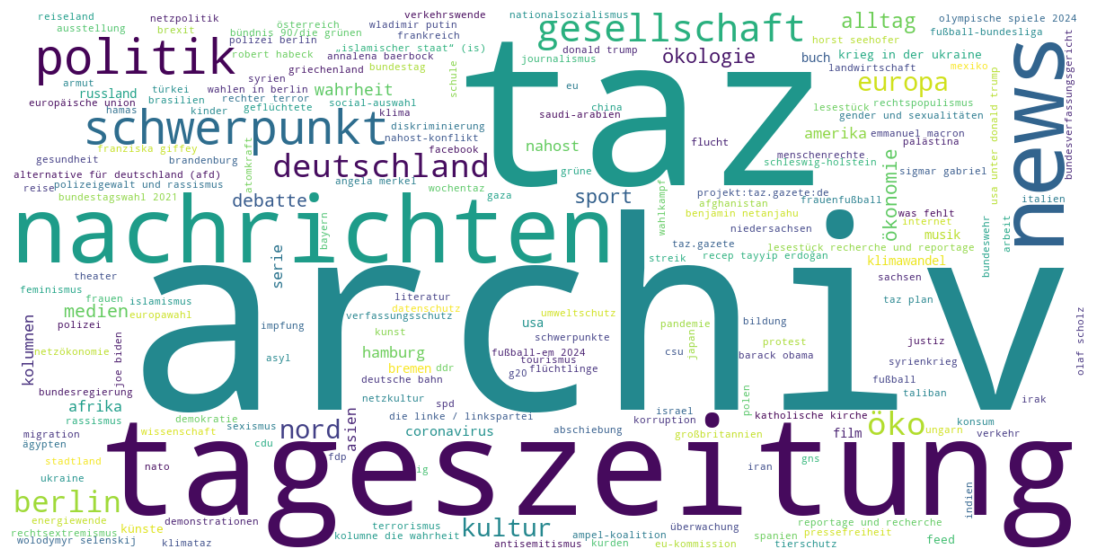

In [ ]:
# choose dataframe (sample preferred)
try:
    src = df_sample
except NameError:
    src = df

# ensure keywords_clean exists
if "keywords" not in src.columns:
    raise ValueError("Column 'keywords_clean' not found. Create it first (as lists of keywords).")

# collect keywords robustly (handles list/ndarray/string/None)
all_kws = []
for entry in src["keywords"]:
    if entry is None:
        continue
    # list-like
    if isinstance(entry, (list, tuple)):
        all_kws.extend([str(x).strip().lower() for x in entry if x and str(x).strip()])
    else:
        # string-like: split on common separators
        s = str(entry)
        parts = [p.strip().lower() for p in __import__("re").split(r"[;,/|]\s*", s) if p.strip()]
        all_kws.extend(parts)

# get frequencies
freq = Counter(all_kws)
if len(freq) == 0:
    raise ValueError("No keywords found after cleaning. Check 'keywords_clean' content.")

# lazy import wordcloud
from wordcloud import WordCloud, STOPWORDS

# optional: extend stopwords if needed
stopwords = set(STOPWORDS)
# stopwords.update(["word_to_exclude"])  # add any domain stopwords here

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=stopwords,
    collocations=False
)

fig = plt.figure(figsize=(14, 7))
wc.generate_from_frequencies(freq)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

This shows that many keywords are just article categories and information which is not super relevant. If the keyoword column is used for the analysis later, we might need to clean it first.

# Turn the df into a parquet

In [27]:
df.to_parquet("df_full_clean.parquet")